# Proj A for CS 135 in Spring 2024

This notebook is specifically for the report related to Problem 1

# Problem 1: Binary Classifier for Bag of Words Classifier

Export the data for loading model later

In [201]:
#imports
import numpy as np
import pandas as pd

In [202]:
x_train_df = pd.read_csv('./data_reviews/x_train.csv')
tr_text_list = x_train_df.values.tolist()

y_train_df = pd.read_csv('./data_reviews/y_train.csv')
tr_label_list = y_train_df.values.tolist()

In [203]:
import pickle


exp_arr = x_train_df.values.tolist()


# Use pickle to serialize and save 'x_train_df' to a file
with open('data_variable.pickle', 'wb') as f:
    pickle.dump(exp_arr, f)


In [204]:
print(x_train_df.shape)

(2400, 2)


# Attempting Bert Encoding

In [205]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    # Tokenize input text and get corresponding IDs
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Generate embeddings for each token
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings and perform mean pooling
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Assuming x_train_df is a DataFrame with your text data
embeddings = np.vstack([get_bert_embeddings(t) for t in x_train_df['text']])


In [206]:
# Sending the y_train_df to a pickle file

y_train_1d_tmp = np.ravel(y_train_df)

with open(('y_train_1d.pickle'), 'wb') as f:
    pickle.dump(y_train_1d_tmp, f)


In [207]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# Split into train and test

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
from proba_metrics import calc_mean_binary_cross_entropy_from_probas
from sklearn.model_selection import cross_val_score

In [209]:
#import plotting libraries
import matplotlib.pyplot as plt

In [210]:
# Changing the printing format
np.set_printoptions(threshold=np.inf)

In [211]:
# split into training and temporary set (combined validation and test)
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(embeddings, y_train_df, test_size=0.4, random_state=42)


# Now split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Finding our ideal C
In this step, we wanted to find the right C value to use in our logistic regression model. To do this, we used some of our code from HW2, which defines a grid of C values and tests BCE on all of these values. We extract the minimum valid error, and using that value as well as some additional context, determine our ideal C.


In [212]:
C_grid = np.logspace(-9, 6, 31)


#use np.ravel to convert arrays to 1d
y_train_1d = np.ravel(y_train)
y_val_1d = np.ravel(y_val)


crossv_scores = list()

# Allocate list for storing LR models
model_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()
te_err_list = list()

num_iterations = 10000

for C in C_grid:
    lr_curr_model = LogisticRegression(solver='lbfgs', C=C, max_iter=num_iterations)
    lr_curr_model.fit(X_train, y_train_1d)

    # append model to list
    model_list.append(lr_curr_model)

    yproba1_tr_M = lr_curr_model.predict_proba(X_train)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_curr_model.predict_proba(X_val)[:,1] # The probability of predicting class 1 on the validation set

    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_train_1d, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_val_1d, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)

    # Compute binary cross-entropy
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_train_1d, yproba1_tr_M)
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_val_1d, yproba1_va_N)

    # Cross validation score
    scores = cross_val_score(lr_curr_model, X_train, y_train_1d, cv=3, scoring='accuracy')


    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

    crossv_scores.append(scores.mean())


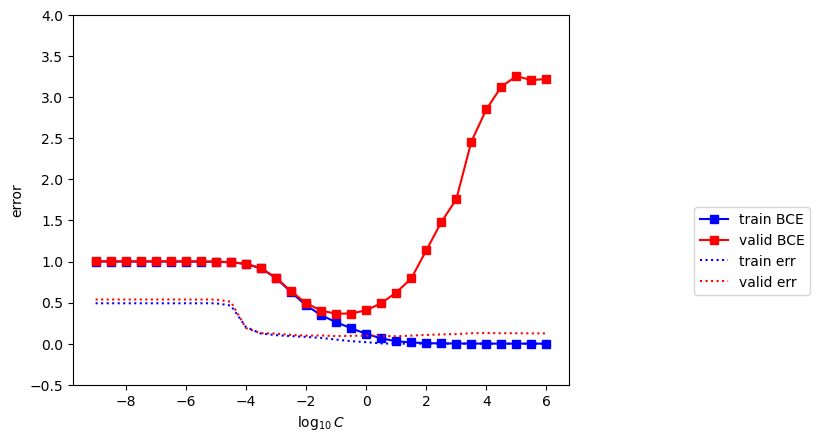

In [213]:
# Plot the error rate and BCE for the training and validation sets

plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([-0.5, 4]);


Finding the best model

In [214]:
min_bce_index = np.argmin(va_bce_list)
max_crossv_index = np.argmax(crossv_scores)
best_C_bce = C_grid[min_bce_index]
best_C_crossv = C_grid[max_crossv_index]

print(f"Best C value for BCE: {best_C_bce}")
print(f"Best C values for Cross Validation: {best_C_crossv}")
print(crossv_scores[max_crossv_index])



Best C value for BCE: 0.1
Best C values for Cross Validation: 0.1
0.9055555555555556


# Finding optimal max iterations

In [215]:
y_test_1d = np.ravel(y_test)
iterations_grid = np.linspace(1, 50, 50).astype(int)
error_grid = []

for iteration_value in iterations_grid:
    lr_curr_model = LogisticRegression(solver='lbfgs', C=best_C_bce, max_iter=iteration_value)
    lr_curr_model.fit(X_train, y_train_1d)

    # Predict on the test set
    y_pred_test = lr_curr_model.predict(X_test)
    
    # Calculate error (for example, using accuracy)
    test_error = 1 - sklearn.metrics.accuracy_score(y_test_1d, y_pred_test)
    
    # Append error to error_grid
    error_grid.append(test_error)
    



/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

(0.0, 1.0)

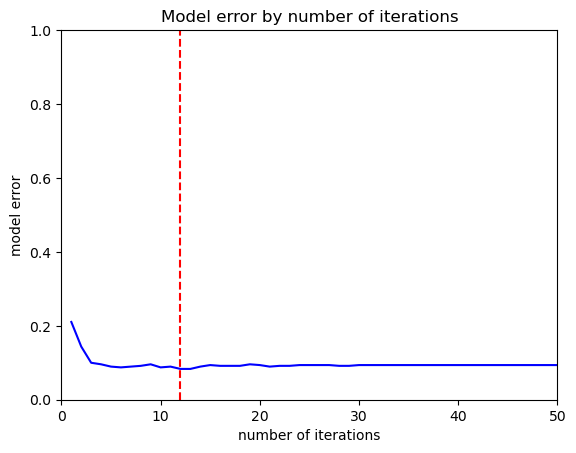

In [216]:

plt.title('Model error by number of iterations')
plt.plot(iterations_grid, error_grid, color='blue')

error_min = np.argmin(error_grid)
plt.axvline(iterations_grid[error_min], color='red', linestyle='--')
plt.xlabel('number of iterations')
plt.ylabel('model error')
plt.xlim(0,50)
plt.ylim(0,1)

In [217]:
print(iterations_grid[error_min])
num_iterations = iterations_grid[error_min]

12


In [353]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Finding best params for no penalty


In [357]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [5, 10, 15, 20, 25, 30]
}

regr = LogisticRegression()

grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train_1d)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Get predictions using the best model
y_pred = best_model.predict(embeddings)

print(best_params)
print(best_model)

/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

{'C': 0.1, 'max_iter': 10}
LogisticRegression(C=0.1, max_iter=10)


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Importing sklearn documentation for confusion matrix.


In [359]:
#get confusion matrix
conf_matrix = confusion_matrix(y_train_df, y_pred)
conf_matrix

array([[1111,   89],
       [ 101, 1099]])

In [360]:
# Perform 3-fold cross-validation
scores = cross_val_score(best_model, embeddings, y_train_1d_tmp, cv=3, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores.round(2))
print("Mean cross-validation score:", scores.mean().round(2))

Cross-validation scores: [0.9  0.87 0.9 ]
Mean cross-validation score: 0.89


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

# Finding best params for L1 penalty
We now try the same process, applying an L1 penalty.

In [361]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [5, 10, 15, 20, 25, 30]
}

regr = LogisticRegression()

grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=0)


# Fit GridSearchCV
grid_search.fit(X_train, y_train_1d)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Get predictions using the best model
y_pred = best_model.predict(embeddings)

print(best_params)
print(best_model)


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reac

/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase t

{'C': 1, 'max_iter': 15, 'penalty': 'l1', 'solver': 'saga'}
LogisticRegression(C=1, max_iter=15, penalty='l1', solver='saga')


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [362]:

# get confusion matrix
conf_matrix = confusion_matrix(y_train_df, y_pred)
conf_matrix


array([[1133,   67],
       [  77, 1123]])

In [363]:
# Perform 3-fold cross-validation
scores = cross_val_score(best_model, embeddings, y_train_df, cv=3, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores.round(2))
print("Mean cross-validation score:", scores.mean().round(2))

/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

Cross-validation scores: [0.91 0.87 0.9 ]
Mean cross-validation score: 0.89


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Finding best params for L2 penalty
We now try the same process, applying an L2 penalty.

In [364]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],
    'max_iter': [5, 10, 15, 20, 25, 30]
}

regr = LogisticRegression()

grid_search = GridSearchCV(regr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train_1d)


# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


#get predictions
y_pred = best_model.predict(embeddings)

print(best_params)
print(best_model)

/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

{'C': 10, 'max_iter': 5, 'penalty': 'l2', 'solver': 'saga'}
LogisticRegression(C=10, max_iter=5, solver='saga')


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [365]:
# get confusion matrix
conf_matrix = confusion_matrix(y_train_df, y_pred)
print(conf_matrix)

[[1117   83]
 [  85 1115]]


In [366]:
# Perform 3-fold cross-validation
scores = cross_val_score(best_model, embeddings, y_train_1d_tmp, cv=3, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores.round(2))
print("Mean cross-validation score:", scores.mean().round(2))

Cross-validation scores: [0.9  0.88 0.9 ]
Mean cross-validation score: 0.89


/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Uploading our best model trained on full data

In [372]:
# classifier1 = LogisticRegression(max_iter= num_iterations, random_state=42, C=best_C_crossv, solver='lbfgs')
# classifier1.fit(X_train, y_train_1d)
regr = LogisticRegression(max_iter=50, C=0.1, solver='saga', penalty='l2')

regr.fit(embeddings, y_train_1d_tmp)


# Use pickle to serialize and save our model to a file
with open('best_model_2.pickle', 'wb') as f:
    pickle.dump(regr, f)



/Users/josephmontalto/miniconda3/envs/cs135_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Finding indices where errors were made

In [377]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

y_pred = regr.predict(embeddings)

# Convert the relevant column of the DataFrame to a NumPy array
y_test_arr = y_train_df['is_positive_sentiment'].values

# Find indices where predictions and correct answers differ
wrong_idx_mask = np.where(y_pred != y_test_arr)[0]

# wrong_idx = y_train_df.index[wrong_idx_mask]




incorrect_predictions_text = x_train_df['text'].iloc[wrong_idx_mask]
sentence_lengths = incorrect_predictions_text.apply(lambda x: len(x.split()))

# Print the indices
# print(incorrect_predictions_text)
# print(sentence_lengths)
print(x_train_df['text'].iloc[wrong_idx_mask])
# print(wrong_idx)


54                                                                                                                                                                                                                         Excellent starter wireless headset.
60                                                                                                                                                                                        Looks nice in the picture, but this case was a huge disappointment!!
61                                                                                                                                               I've had this bluetoooth headset for some time now and still not comfortable with the way it fits on the ear.
77                                                                                                                                                                              Still Waiting...... I'm sure this item would work well.. if